In [1]:
import pandas as pd
import isn_tractor.ibisn_lite as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()  
os.chdir("Data//")

Filtration curve re-definition

In [3]:
def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    return lines


In [21]:
def analyze_network_data(data, type_analysis="Strength", abs_val=True, thr_values=None, label_column='label',stats = "Strenght"):
    controls_list = {}
    cases_list = {}

    def preprocess_data(data, label_column):
        data.index.name = None

        if label_column is not None:
            data_controls = data[data[label_column] == 0]
            data_cases = data[data[label_column] == 1]

            # Drop the label column
            data_controls.drop([label_column], axis=1, inplace=True)
            data_cases.drop([label_column], axis=1, inplace=True)

            # Transpose the dataframes and reset the index
            cases = data_cases.T.reset_index()
            controls = data_controls.T.reset_index()

            # Split the values in the index column by "_"
            cases[['N1', 'N2']] = cases['index'].str.split("_", expand=True)
            cases.drop(['index'], axis=1, inplace=True)

            controls[['N1', 'N2']] = controls['index'].str.split("_", expand=True)
            controls.drop(['index'], axis=1, inplace=True)

            return controls, cases

        else:
            return data

    data = preprocess_data(data, label_column)

    def process_data(data, data_list, thr):
        for i in range(data.shape[1] - 2):
            temp = data.iloc[:, [data.shape[1] - 2, data.shape[1] - 1, i]].copy()
            if abs_val:
                temp.iloc[:, 2] = np.abs(temp.iloc[:, 2])
            aa = temp.columns[2]
            temp.columns = ["E1", "E2", "Weight"]
            mygraph = nx.from_pandas_edgelist(temp, "E1", "E2", "Weight")
            gg = nx.to_numpy_array(mygraph, weight="Weight")
            data_list[aa] = gg

    process_data(data[0], controls_list, thr_values)
    process_data(data[1], cases_list, thr_values)

    num_controls = len(controls_list)
    num_cases = len(cases_list)
    if thr_values is None:
        thr_values = np.arange(-4, 4, 0.03)
    FC1 = np.zeros((num_controls, len(thr_values)))
    FC2 = np.zeros((num_cases, len(thr_values)))

    def calculate_FC(data_list, FC):
        for indv in range(len(data_list)):
            nm_l = list(data_list.keys())[indv]
            Adj = data_list[nm_l]
            for i in range(len(thr_values)):
                Adj_bin = np.where((Adj > thr_values[i]) & (Adj != 0), 1, 0)
                g = nx.from_numpy_array(Adj_bin, create_using=nx.Graph)
                if stats == "N_edges":
                    FC[indv, i] = g.number_of_edges()
                    print("ciao")
                else:
                    FC[indv, i] = g.size()
    calculate_FC(controls_list, FC1)
    calculate_FC(cases_list, FC2)

    df_controls = pd.DataFrame({"Thr": thr_values, "Mean": np.mean(FC1, axis=0), "sd": np.std(FC1, axis=0), "cl": ["Controls"] * len(thr_values)})
    df_cases = pd.DataFrame({"Thr": thr_values, "Mean": np.mean(FC2, axis=0), "sd": np.std(FC2, axis=0), "cl": ["Cases"] * len(thr_values)})
    df = pd.concat([df_controls, df_cases])

    plt.figure(figsize=(12, 10))
    color_mapping = {'Cases': 'red', 'Controls': 'blue'}
    plt.errorbar(df_controls["Thr"], df_controls["Mean"], yerr=df_controls["sd"], elinewidth=0.5)
    plt.errorbar(df_cases["Thr"], df_cases["Mean"], yerr=df_cases["sd"], elinewidth=0.5, color="red")

    # Add labels to the x-axis and y-axis
    plt.xlabel("Threshold Values")
    plt.ylabel("Graph Statistic:"+ stats)

    # Create legend based on color_mapping
    labels = list(color_mapping.keys())
    handles = [plt.Line2D([], [], color=color_mapping[label], marker='o', linestyle='-') for label in labels]
    plt.legend(handles, labels)

    plt.show()


Loading the data and converting the phenotype to binary

In [5]:
expr = pd.read_csv("expression.csv")
clinic = pd.read_csv("answer.csv")
clinic['mets'] = clinic['mets'].replace({'yes': 1, 'no': 0})

expr.shape, clinic.shape

((53, 10001), (53, 3))

Reading top50 edges (and the corresponding node) as in LionessR

In [6]:
Edge_top50 = read_txt_file('topEdges_names.txt')
Nodes_top50 = read_txt_file('topNodes_names.txt')


Reducing to the top 50 nodes

In [7]:
expr_red = expr.loc[:, Nodes_top50]
expr_red.shape

(53, 60)

In [8]:
ISNs = pd.DataFrame(it.dense_isn(expr_red)).astype(float)
ISNs.shape

(53, 3600)

Rename the ISn's rows and columns

In [9]:
a = np.repeat(expr_red.columns, expr_red.shape[1])
b = np.tile(expr_red.columns, expr_red.shape[1])
ISNs.columns = [a[i]+'_'+b[i] for i in range(expr_red.shape[1]**2)]
print(ISNs.shape)

(53, 3600)


In [10]:
ISNs_top50 = ISNs.loc[:, Edge_top50]
ISNs_top50

,BGLAP_MMP11,MFAP4_FKSG30,MFAP4_CSPG2,CSPG2_MXRA5,COL8A1_H19,PTHR1_DSPG3,CXCL10_HOMER2,CSPG2_DDIT4L,TMSL8_SRPX,BGLAP_HLA-DQB1,...,CCDC3_STAT1,SEPP1_STAT1,CD36_STAT1,HOMER2_STAT1,GYG2_STAT1,ENPP2_STAT1,ID3_STAT1,SCIN_STAT1,FOSB_SLC29A4,SRPX_TNFSF10
0,0.641798,0.504648,0.853662,1.167473,1.097080,-0.464795,0.319163,0.647703,-1.323883,0.062316,...,0.001818,-0.049767,-0.042618,-0.089039,-0.139601,-0.088789,0.036434,0.252409,-0.221392,0.530984
1,1.886800,0.275692,0.265402,0.326565,0.236828,-0.151212,-0.446455,0.783797,-0.582327,2.421968,...,-0.066339,0.167064,-0.089342,-0.214393,-0.124924,-0.028599,-0.164280,-0.160417,0.601500,0.576209
2,0.024638,0.517723,0.881114,0.744101,1.406609,-0.057858,-0.372206,0.801260,-0.350670,0.135101,...,-0.300657,0.052788,0.149995,-0.311417,-0.254936,-0.087763,-0.230595,0.059261,0.114666,-0.505547
3,1.507184,0.625956,0.556595,0.079836,0.248182,-0.726794,1.199114,-0.176077,-0.623453,0.225021,...,1.499875,0.127208,0.204040,1.282603,-0.833543,0.839092,0.198952,-1.395678,-0.093625,1.945061
4,0.069360,0.378572,0.727813,0.220823,0.254874,-0.206210,-0.122026,-0.451120,0.110950,0.106794,...,-0.163801,-0.131425,-0.071446,-0.223004,-0.120877,-0.035177,-0.160453,-0.181023,0.226879,0.031367
5,-0.513293,-0.085167,0.633777,-0.041498,0.038414,-0.993717,1.739272,0.319855,-1.549774,0.635792,...,2.059759,1.661265,2.281886,2.662919,1.029231,0.451092,2.126722,1.614871,-0.247757,0.157543
6,-0.842686,1.366416,1.384827,2.126852,0.222280,-0.708319,2.155769,1.681117,-1.551971,-1.777765,...,-0.473574,-0.031564,-0.054265,-0.952908,-0.134045,-0.425227,-0.627358,-0.384815,0.246661,1.074346
7,0.167951,-0.131851,0.052799,0.568296,0.056290,1.108846,-1.318907,0.009171,-0.020866,-1.101309,...,-1.231950,-0.447977,-1.274185,-0.900358,-0.827455,-0.539279,-0.796152,-0.827994,0.323534,0.070781
8,-0.348831,-0.871861,0.052528,0.373709,-0.686712,-0.197988,0.534804,0.079466,0.077123,-0.020710,...,-0.127622,0.066872,-0.010167,0.129423,-0.022574,-0.139390,-0.117913,-0.211018,0.386766,0.086158
9,-1.231631,-0.912816,-0.761634,-0.611290,-0.281359,-0.187895,0.631094,0.179977,-1.058209,-1.202326,...,-0.097798,-0.042741,-0.046559,-0.228084,-0.134148,-0.001658,-0.122113,-0.157969,0.722212,-0.225545


In [11]:
ISNs_top50 = ISNs_top50.rename(index=clinic["sample"])
clinic = clinic.rename(index=clinic["sample"])
df = pd.concat([ISNs_top50, clinic['mets']], axis=1)
df.shape

(53, 51)

C:\Users\fmelo\AppData\Local\Temp\ipykernel_28432\1458918153.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_controls.drop([label_column], axis=1, inplace=True)
C:\Users\fmelo\AppData\Local\Temp\ipykernel_28432\1458918153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cases.drop([label_column], axis=1, inplace=True)


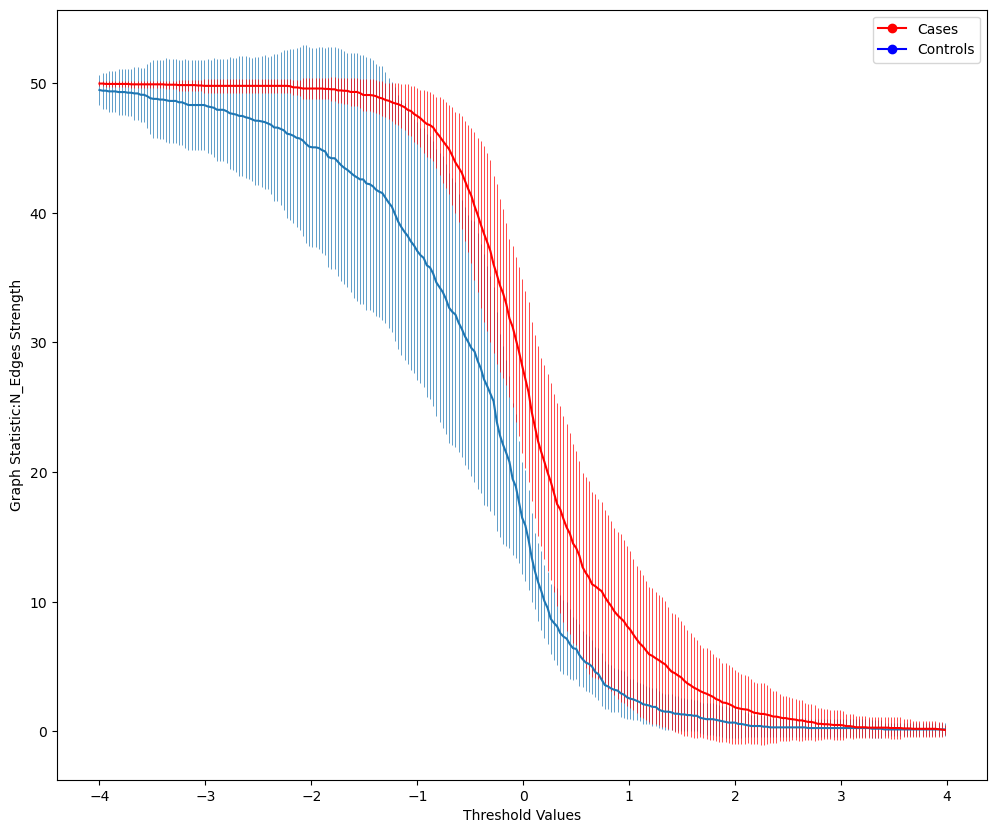

In [22]:
analyze_network_data(df, label_column='mets', abs_val=False, stats = "N_Edges")